In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

from datetime import datetime
plt.rcParams['agg.path.chunksize'] = 100

In [ ]:
from scipy.stats import norm
import sys
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def to_datatime(date):
    try:
        return  pd.to_datetime(date, format='%Y/%m/%d')
    except:
        return  pd.to_datetime(date, format='%Y-%m-%d')

In [ ]:
def convert(x):
    if x==None:
        return np.nan
    return np.float64(x)

## Importing and formatting the dataset

In [ ]:
data = pd.read_excel("/content/drive/My Drive/Monte carlo simulation/data.xlsx", "GDP")
data = data[["Year", "GDP(Actual)"]]
data.columns = ["date_txn", "GDP"]
data["date_txn"] = data["date_txn"].apply(lambda x: str(x)+"-01-"+"01")

data.drop_duplicates(subset="date_txn", inplace=True)
data["date_txn"]=data["date_txn"].apply(to_datatime)
data=data.set_index("date_txn")


by_date=data.sort_index(ascending=True)
for column in by_date.columns:
    by_date[column]=by_date[column].apply(lambda x: convert(x))
by_date.head()

,GDP
date_txn,
1960-01-01,3.653593e+10
1961-01-01,3.870910e+10
1962-01-01,4.159907e+10
1963-01-01,4.777600e+10
1964-01-01,5.572687e+10


In [ ]:
def format_ts(ts):
    ts=ts.dropna()
    #Removing the outliers
    ts=ts[~((ts-ts.mean()).abs()>3*ts.std())]
    return ts
    

In [ ]:
from pandas.tseries.offsets import *
def get_predicted_dateset(df, prediction_start_index, num_predictions):

    future_dates = [df.index[prediction_start_index] + DateOffset(years=x) for x in range(0,num_predictions) ][::-1]

    #print("Future dates: ", future_dates)
    return future_dates
    #return list(df.index[prediction_start_index-num_predictions:prediction_start_index])

In [ ]:
def get_max_min_each_index(predicted_list):
    min_list=[]
    max_list=[]
    avg_list=[]
    difference_list=[]
    for i in range(len(predicted_list[0])):
        column=[row[i] for row in predicted_list]
        min_list.append(min(column))
        max_list.append(max(column))
    for x,y in list(zip(min_list, max_list)):
        avg_list.append((x+y)/2.0)
    
    for x,y in list(zip(min_list, max_list)):
        difference_list.append(np.abs(x-y))
    avg_difference=np.mean(difference_list)
    min_list=list(map(lambda x: x-avg_difference/2.0, predicted_list[0].values))
    max_list=list(map(lambda x: x+avg_difference/2.0, predicted_list[0].values))
    
    date=list(predicted_list[0].index)
    
    prediction = pd.DataFrame()
    prediction["Date"]=date
    prediction["max_expected_val"]=max_list
    prediction["min_expected_val"]=min_list
    prediction["Prediction"]=predicted_list[0].values
    prediction.set_index("Date", inplace=True)
        
    return prediction

In [ ]:
plt.plot(format_ts(by_date[column]), color="blue", label="Actual "+column, linewidth=7.0)

## Function to generate random plots

In [ ]:
def generate_random_plot(df, prediction_start_date, num_predictions, column):
    
    prediction_start_index=list(df.index).index(pd.to_datetime(str(prediction_start_date)))
    
    ts=df[str(column)]
    ts=format_ts(ts)
    log_returns = np.log(1 + ts.pct_change())
    
    u = log_returns.iloc[:prediction_start_index].mean()
    var = log_returns.iloc[:prediction_start_index].var()
    stdev = log_returns.iloc[:prediction_start_index].std()
    drift = u -(0.5 * var)
    
   
    random_values =  norm.ppf(np.random.rand(num_predictions, 1))
    if drift>0:
      for i in range(len(random_values)):
        if random_values[i][0] <-0.75:
          random_values[i][0] =0
    else:
      for i in range(len(random_values)):
        if random_values[i][0] >0.75:
          random_values[i][0] =0


    

    daily_returns = np.exp(drift + stdev *random_values  )
    
    
    last_val = df.iloc[prediction_start_index][column]
    price_list = np.zeros_like(daily_returns)
    price_list[0] = last_val
    
    
    for t in range(1, num_predictions):
        price_list[t] = price_list[t-1] * daily_returns[t]

    avg_list=[]
    for arr in price_list:
        avg_list.append(np.sum(arr)/len(arr))
        
    avg_list=avg_list[::-1]
        
    pred_series=pd.Series(avg_list, index=get_predicted_dateset(df, prediction_start_index, num_predictions))
    
    return pred_series
    
    
    
    

## Function to select the best most probable plot from the random plots as our predictions

In [ ]:
def predict_best_ts(df, prediction_start_date, num_predictions, column, num_pastdays=10, number_of_simulations_of_random_plots = 5000):
    
    prediction_start_index=list(df.index).index(pd.to_datetime(str(prediction_start_date)))-num_pastdays
    accuracy_prediction_start_date=str(df.index[prediction_start_index].date())
    accuracy_upto_index=prediction_start_index+num_pastdays
    # print("Accuracy prediction start date: ", accuracy_prediction_start_date)
    # print("Accuracy prediction start index: ", prediction_start_index)
    
    
    acutal_values_series=df.iloc[prediction_start_index : accuracy_upto_index][str(column)]
    predicted_series_list=[]
    error_list=[]
    iterations= number_of_simulations_of_random_plots
    
    for i in range(iterations):
        
        total_prediction=generate_random_plot(df, accuracy_prediction_start_date, num_pastdays+num_predictions, column)
        #print("Random plot length: ", len(total_prediction.index))
        # print("Random plot sample")
        # print(total_prediction)
        #current_random_plot_prediction_start_index=list(total_prediction.index).index(pd.to_datetime(str(prediction_start_date)))-num_pastdays
        #current_random_plot_accuracy_upto_index=current_random_plot_prediction_start_index+num_pastdays
        # print("current random plot start index", current_random_plot_prediction_start_index)
        # print("current_random_plot_accuracy_upto_index", current_random_plot_accuracy_upto_index)
        #return
        prediction_accuracy_testseries=total_prediction.iloc[: num_pastdays]
        
        error=metrics.mean_squared_error(prediction_accuracy_testseries, acutal_values_series)
        error_list.append(error)
        predicted_series_list.append(total_prediction)
        
    error_list=map(abs, error_list)    
    min_error_index=error_list.index(min(error_list))
    lst=list(zip(predicted_series_list, error_list))
    lst=sorted(lst, key=lambda x: x[1])
    predicted_series_list=[]
    for predicted_series, error in lst[:1]:
      predicted_series_list.append(predicted_series)
        
    #win=5
    #predicted_series=predicted_series_list[min_error_index].iloc[:win-1].append(predicted_series_list[min_error_index].rolling(window=win).mean().iloc[(win-1):])
    #return predicted_series_list[min_error_index].rolling(window=win).mean().iloc[(win-1):]
    return get_max_min_each_index(predicted_series_list)
  

In [ ]:
def mape_error(actual_values, predicted_values):
  actual_values = list(actual_values)
  predicted_values = list(predicted_values)
  percentage = 0
  for i in range(len(actual_values)):
    percentage += (abs(predicted_values[i]-actual_values[i])/actual_values[i])*100
  return percentage/len(actual_values)

# Setting the parameters and doing the predictions
Enter the date from which prediction has to be initiated in string form

Enter the number of predictions required

Enter the column name to be predicted

In [ ]:
prediction_start_date="2005-01-01"
column="GDP"
num_predictions= len(list(by_date.index)) - list(by_date.index).index(pd.to_datetime(prediction_start_date)) 
units_of_backtracking = 23
number_of_simulations_of_random_plots = 500

In [ ]:
lead_1_prediction=predict_best_ts(by_date, prediction_start_date=prediction_start_date, column=column, 
                                  num_predictions=num_predictions, num_pastdays= units_of_backtracking,
                                  number_of_simulations_of_random_plots = number_of_simulations_of_random_plots)
prediction_chart = lead_1_prediction.iloc[:num_predictions][["Prediction"]]
prediction_chart.columns =["Predicted "+column]
prediction_chart["Actual "+column] = list(by_date.iloc[list(by_date.index).index(pd.to_datetime(prediction_start_date)): list(by_date.index).index(pd.to_datetime(prediction_start_date))+num_predictions][column])[::-1]
pd.set_option('display.float_format', lambda x: '%.3f' % x)
prediction_chart = prediction_chart.dropna()
prediction_chart

,Predicted GDP,Actual GDP
Date,,
2017-01-01,2359641552651.956,2600818243559.646
2016-01-01,2310402263839.694,2274229710530.474
2015-01-01,2054689096815.379,2102390808996.693
2014-01-01,1953314804883.618,2039127446298.550
2013-01-01,1913884313473.492,1856722121394.535
2012-01-01,1864287294868.570,1827637859135.696
2011-01-01,1730835771435.740,1823049927771.459
2010-01-01,1515728704894.283,1656617073124.213
2009-01-01,1354696753744.219,1323940295874.900


## Function tto record the effect of Backtracking on the accuracy(MAPE) of predction

In [ ]:
def recording_backtracking_vs_mape(prediction_start_date, column, num_predictions, number_of_simulations_of_random_plots):
  mape_list = []
  units_of_backtrack = []
  for i in range(1, 30):
    try:
      
      lead_1_prediction=predict_best_ts(by_date, prediction_start_date=prediction_start_date, column=column, 
                                    num_predictions=num_predictions, num_pastdays= i,
                                    number_of_simulations_of_random_plots = number_of_simulations_of_random_plots)
      prediction_chart = lead_1_prediction.iloc[:num_predictions][["Prediction"]]
      prediction_chart.columns =["Predicted "+column]
      prediction_chart["Actual "+column] = list(by_date.iloc[list(by_date.index).index(pd.to_datetime(prediction_start_date)): list(by_date.index).index(pd.to_datetime(prediction_start_date))+num_predictions][column])[::-1]
      prediction_chart.dropna(inplace=True)
      mape = mape_error(prediction_chart["Actual "+column], prediction_chart["Predicted "+column])
      if mape <100:
        mape_list.append(mape)
        units_of_backtrack.append(i)
      print("Units of backtrack: ", i, " MAPE: ", mape)
      
    except:
      print("units of backtrack ", i, "failed")

  result = pd.DataFrame()
  result["Units of backtracking"] = units_of_backtrack
  result["MAPE"] = mape_list
  result = result.set_index("Units of backtracking")
  result.plot()
  return result


('Units of backtrack: ', 1, ' MAPE: ', 37.622131298697944)
('Units of backtrack: ', 2, ' MAPE: ', 44.41070028991563)
('Units of backtrack: ', 3, ' MAPE: ', 49.24409544739646)
('Units of backtrack: ', 4, ' MAPE: ', 52.11509856827729)
('Units of backtrack: ', 5, ' MAPE: ', 54.223032640221035)
('Units of backtrack: ', 6, ' MAPE: ', 47.23839803167475)
('Units of backtrack: ', 7, ' MAPE: ', 49.247544076480544)
('Units of backtrack: ', 8, ' MAPE: ', 41.76312004821653)
('Units of backtrack: ', 9, ' MAPE: ', 45.27113755086801)
('Units of backtrack: ', 10, ' MAPE: ', 49.98426616040504)
('Units of backtrack: ', 11, ' MAPE: ', 54.63807734492229)
('Units of backtrack: ', 12, ' MAPE: ', 55.95322991730419)
('Units of backtrack: ', 13, ' MAPE: ', 57.7328730729192)
('Units of backtrack: ', 14, ' MAPE: ', 43.336907792581606)
('Units of backtrack: ', 15, ' MAPE: ', 34.00933077157713)
('Units of backtrack: ', 16, ' MAPE: ', 26.664912960616086)
('Units of backtrack: ', 17, ' MAPE: ', 15.310039066223803)
(

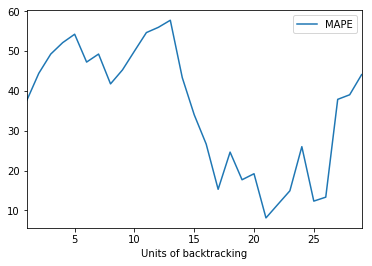

In [ ]:
result = recording_backtracking_vs_mape(prediction_start_date = prediction_start_date, 
                               column = column, 
                               num_predictions = num_predictions,
                               number_of_simulations_of_random_plots = number_of_simulations_of_random_plots)

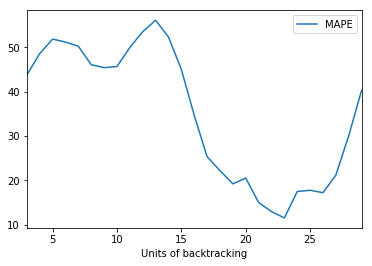

In [ ]:
r = pd.DataFrame()
r["MAPE"] = result["MAPE"].rolling(3).mean()
r["Units of backtracking"] = list(result.index)
r = r.dropna()
r = r.set_index("Units of backtracking")
r.plot()

## Plot summarizing the prediction process


In [ ]:
lead_1_prediction = lead_1_prediction.dropna()

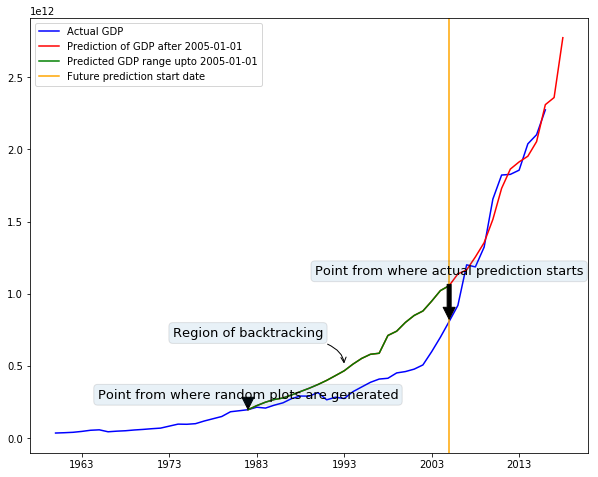

In [ ]:
plt.plot(format_ts(by_date[column]), color="blue", label="Actual "+column)
#plt.plot(pred_lead_1[:prediction_start_date], color="red", label="Predicted lead_1 after : "+str(prediction_start_date))
plt.plot(lead_1_prediction[["Prediction"]], color="red", label="Prediction of "+column+" after "+str(prediction_start_date))
plt.plot(lead_1_prediction[["Prediction"]][prediction_start_date:], color="green", label="Predicted "+column+" range upto "+str(prediction_start_date)+"")
plt.axvline(x=pd.to_datetime(str(prediction_start_date)),  color="orange", label="Future prediction start date")
plt.plot(x =pd.to_datetime(str(prediction_start_date)))
plt.annotate('Point from where actual prediction starts', xy=(pd.to_datetime(str(prediction_start_date)), 
             by_date.loc[pd.to_datetime(str(prediction_start_date))][column]), xytext=(pd.to_datetime(str(prediction_start_date)), 1.4*by_date.loc[pd.to_datetime(str(prediction_start_date))][column]),
             size=13,
             ha='center',
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Point from where random plots are generated', xy=(lead_1_prediction.index[-1], 
             by_date.loc[lead_1_prediction.index[-1]][column]), xytext=(lead_1_prediction.index[-1], 1.4*by_date.loc[lead_1_prediction.index[-1]][column]),
             size=13,
             ha='center',
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('Region of backtracking', xy=(lead_1_prediction.index[(len(list(lead_1_prediction.index)) + list(lead_1_prediction.index).index(pd.to_datetime(str(prediction_start_date))))//2], 
             (by_date.loc[lead_1_prediction.index[-1]][column] + by_date.loc[pd.to_datetime(str(prediction_start_date))][column])//2), 
             xytext=(lead_1_prediction.index[-1], 0.7*(by_date.loc[lead_1_prediction.index[-1]][column] + by_date.loc[pd.to_datetime(str(prediction_start_date))][column])),
             size=13,
             ha='center',
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"))
#plt.text(pd.to_datetime(str(prediction_start_date)), 0, "chut", arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()

## Plot depicting random plot generation and customization

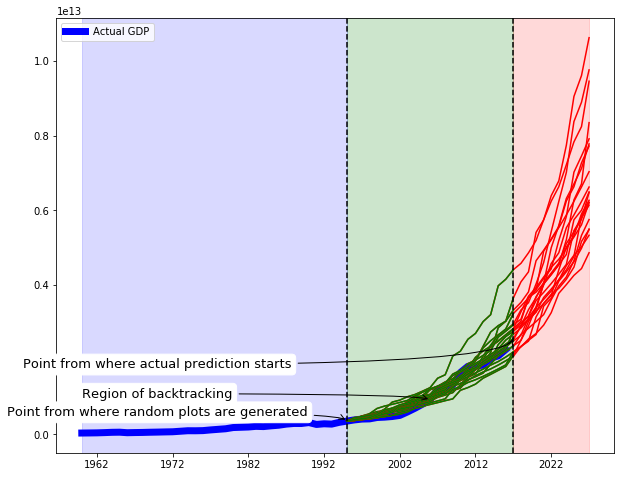

In [ ]:
# random_plot = get_max_min_each_index([generate_random_plot(by_date, prediction_start_date, num_predictions, column)])[["Prediction"]]

plt.plot(format_ts(by_date[column]), color="blue", label="Actual "+column, linewidth=7.0)
#plt.plot(pred_lead_1[:prediction_start_date], color="red", label="Predicted lead_1 after : "+str(prediction_start_date))
for random_plot in random_plots:
  try:
    plt.plot(random_plot[["Prediction"]], color="red")
    plt.plot(random_plot[["Prediction"]][str(by_date.index[-1]) : prediction_start_date], color="green")
  except:
    continue
plt.axvline(x=pd.to_datetime(str(prediction_start_date)),  color="black", linestyle ="--")
plt.axvline(x=pd.to_datetime(str(by_date.index[-1])), linestyle ="--",  color="black")
plt.axvspan(pd.to_datetime(str(prediction_start_date)), pd.to_datetime(str(by_date.index[-1])), alpha=0.2, color='green')
plt.axvspan( pd.to_datetime(str(by_date.index[0])), pd.to_datetime(str(prediction_start_date)), alpha=0.15, color='blue')
plt.axvspan(by_date.index[-1], random_plots[0].index[0], alpha=0.15, color='red')
plt.plot(x =pd.to_datetime(str(prediction_start_date)))
plt.annotate('Point from where actual prediction starts', xy=(by_date.index[-1], 
             by_date.iloc[-1][column]), xytext=(by_date.index[10], 5*by_date.loc[pd.to_datetime(str(prediction_start_date))][column]),
             size=13,
             ha='center',
             bbox=dict(boxstyle="round", alpha=1.0, color = "white"),
             arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Point from where random plots are generated', xy=(pd.to_datetime(str(prediction_start_date)), 
             by_date.loc[pd.to_datetime(str(prediction_start_date))][column]), xytext=(by_date.index[10], 1.4*by_date.loc[pd.to_datetime(str(prediction_start_date))][column]),
             size=13,
             ha='center',
             bbox=dict(boxstyle="round", alpha=1.0, color = "white"),
             arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"))

plt.annotate('Region of backtracking', xy=(by_date.index[(len(list(by_date.index)) +  list(by_date.index).index(pd.to_datetime(prediction_start_date)) )//2], 
             by_date.iloc[ (list(by_date.index).index(pd.to_datetime(prediction_start_date)) + len(list(by_date.index)) )//2 ][column]), 
             xytext=(by_date.index[10], 1.4*(by_date.loc[random_plot.index[-1]][column] + by_date.loc[pd.to_datetime(str(prediction_start_date))][column])),
             size=13,
             ha='center',
             bbox=dict(boxstyle="round", alpha=1.0, color = "white"),
             arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"))
#plt.text(pd.to_datetime(str(prediction_start_date)), 0, "chut", arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()

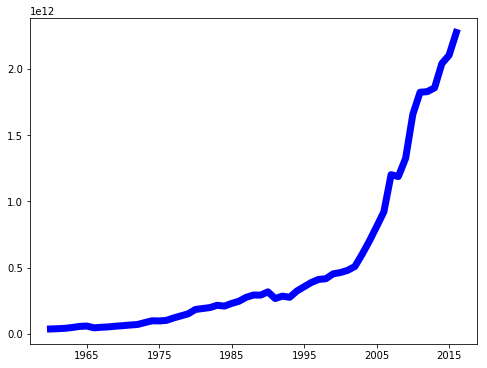

In [ ]:
plt.plot(format_ts(by_date[column]), color="blue", label="Actual "+column, linewidth=7.0)